## Understanding Netflix ##

Netflix is a popular streaming service that hosts numerous TV Shows and Movies. This notebook contains analysis of Netflix 2019 data obtained from [Kaggle](https://www.kaggle.com/shivamb/netflix-shows). By analyzing this dataset one can get an overview of the content available based on geographies. 

From the **Business** viewpoint, the analysis aims to answer the following questions :

1. Which countries have the most content on Netflix
2. How is the Nextflix content growing with regards to Movies and TV Shows
3. Which are the Top TV Shows by season
4. Build a simple recommender for shows and movies




**Importing Libraries**

In [233]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sea
import matplotlib.style as style
style.use('fivethirtyeight')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [169]:
netflix_data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016-09-09,2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2018-09-08,2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2018-09-08,2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017-09-08,2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [13]:
netflix_data.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

#### Null values in the datset

In [16]:
netflix_data.isnull().sum()

show_id            0
type               0
title              0
director        1969
cast             570
country          476
date_added        11
release_year       0
rating            10
duration           0
listed_in          0
description        0
dtype: int64

In [20]:
percent_null = ((netflix_data.isnull().sum()/netflix_data.isnull().count()).sort_values(ascending=False))*100


In [21]:
percent_null

director        31.584857
cast             9.143407
country          7.635547
date_added       0.176452
rating           0.160411
description      0.000000
listed_in        0.000000
duration         0.000000
release_year     0.000000
title            0.000000
type             0.000000
show_id          0.000000
dtype: float64

As we can see above **31%** of the **'director'** values are missing followed by **9% 'cast'** and **7% 'country'**. Missing values for 'date_added' and 'rating' is significantly less 

#### Datatypes and  conversion, handling missing values, duplicates 

In [28]:
netflix_data.dtypes

show_id          int64
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

**date_added** needs to be converted to date time object and has null values, as rating is string for missing values we can use mode to fill -- a safe assumption. For the missing values in the **director** (can have mutiple values) column and **country** and **cast** (can have multiple values) also **date_added** ; leave missing values as is. I will drop the rows without date_added for analysis

In [31]:
netflix_data['date_added'] = pd.to_datetime(netflix_data['date_added'])
netflix_data.dtypes

show_id                  int64
type                    object
title                   object
director                object
cast                    object
country                 object
date_added      datetime64[ns]
release_year             int64
rating                  object
duration                object
listed_in               object
description             object
dtype: object

In [26]:
netflix_data['rating'] = netflix_data['rating'].fillna(netflix_data['rating'].mode()[0])
netflix_data['rating'].value_counts()

TV-MA       2037
TV-14       1698
TV-PG        701
R            508
PG-13        286
NR           218
PG           184
TV-Y7        169
TV-G         149
TV-Y         143
TV-Y7-FV      95
G             37
UR             7
NC-17          2
Name: rating, dtype: int64

In [30]:
netflix_data['rating'].isnull().sum()


0

### TV Shows Vs. Movies in the dataset

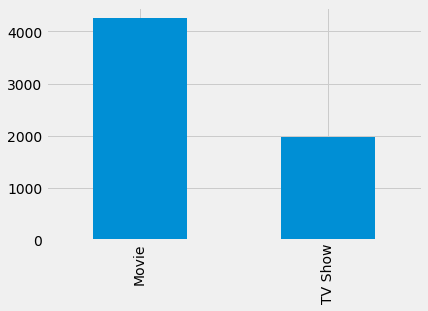

In [117]:
netflix_data.type.value_counts().plot(kind='bar')


In [118]:
netflix_data.type.value_counts()

Movie      4265
TV Show    1969
Name: type, dtype: int64

**Are the Movies and TV shows Balanced in the dataset over the years** ? *(Question 2)--How is the Nextflix content growing with regards to Movies and TV Shows*

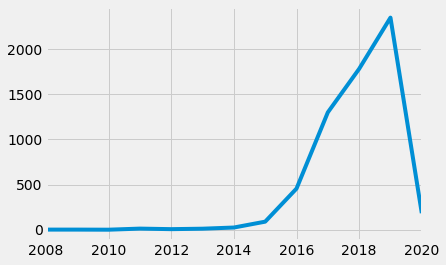

In [44]:
netflix_data.date_added.dt.year.dropna().astype(int).value_counts().sort_index().plot()


There is a sharp decline after 2019 it's proabably because the dataset contains few data points for 2020, let us explore

In [89]:
(np.sum(netflix_data.date_added.dt.year == 2020), (np.sum(netflix_data.date_added.dt.year == 2019)))

(184, 2349)

In [190]:
pd.crosstab(netflix_data.type,netflix_data.date_added.dt.year.dropna(),margins=True).style.background_gradient(cmap='PuBu')

date_added,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,All
type,,,,,,,,,,,,,,
Movie,1,2,1,13,4,6,19,58,264,913,1290,1546,147,4264
TV Show,1,0,0,0,3,6,6,32,192,387,492,803,37,1959
All,2,2,1,13,7,12,25,90,456,1300,1782,2349,184,6223


we can see in the dataset significantly more movies are added starting **2016**

### Country content Analysis 

**Which countries are having the most content on Netflix? (Question1)**

In [152]:

top_20_countries = netflix_data['country'].value_counts().sort_values(ascending=False)[:20]


In [159]:
top_20_countries

United States                    2032
India                             777
United Kingdom                    348
Japan                             176
Canada                            141
South Korea                       136
Spain                             117
France                             90
Mexico                             83
Turkey                             79
Australia                          71
Taiwan                             69
Hong Kong                          51
Egypt                              50
United Kingdom, United States      50
China                              50
Thailand                           50
Brazil                             50
Philippines                        44
Indonesia                          44
Name: country, dtype: int64

Note that some content is avilable in multiple countries as seen above like United Kingdom, United States

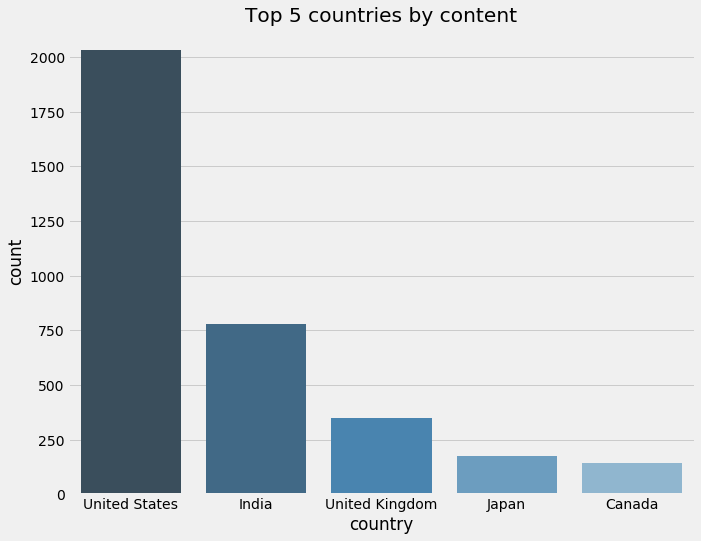

In [166]:

plt.figure(figsize=(10,8))
plt.title("Top 5 countries by content")
sea.countplot(x = "country", 
              order=netflix_data['country'].value_counts().index[0:5] ,data= netflix_data,palette='Blues_d')

This is the overall content. However let's split by TV shows and movies and see if the order remains the same 

In [171]:
movies = netflix_data[netflix_data['type'] == 'Movie']
tv_shows = netflix_data[netflix_data['type'] == 'TV Show']

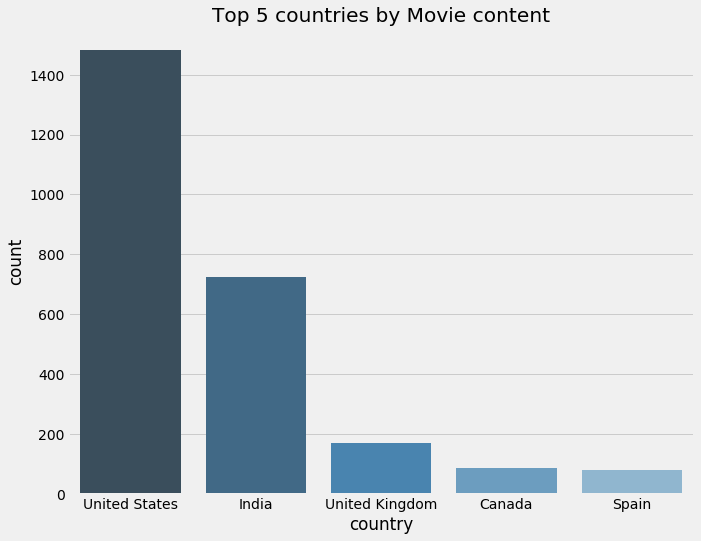

In [185]:
plt.figure(figsize=(10,8))
plt.title("Top 5 countries by Movie content")
sea.countplot(x = "country", 
              order=movies.country.value_counts().index[0:5] ,data= movies,palette='Blues_d')

Japan is out of the top 5 and Spain is in !

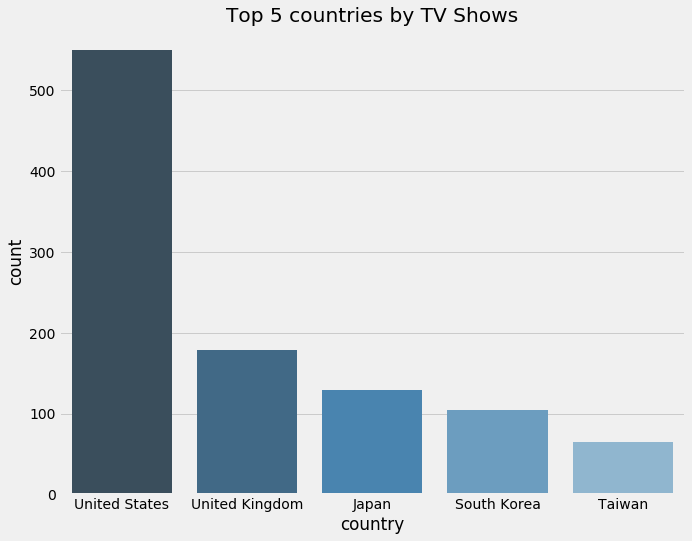

In [186]:
plt.figure(figsize=(10,8))
plt.title("Top 5 countries by TV Shows")
sea.countplot(x = "country", 
              order=tv_shows.country.value_counts().index[0:5] ,data= tv_shows,palette='Blues_d')

Intresting to see that India is out of top 5 for TV shows. It's quite possible that Indian demographic prefer **Movies** to **TV Show** however, a much deeper analyis is needed to validate the claim 

In [188]:
tv_shows.country.value_counts()[:20]

United States            550
United Kingdom           178
Japan                    129
South Korea              104
Taiwan                    65
Canada                    53
India                     53
France                    40
Australia                 39
Spain                     37
China                     31
Mexico                    29
Turkey                    24
Thailand                  17
Colombia                  16
Brazil                    15
Argentina                 12
Russia                    12
United States, Canada     12
Canada, United States     12
Name: country, dtype: int64

we see that India is the 6th place tied with cannada if we have viewer pattern data then we could dig in deeper but the data set is limited

**Let's explore the rating distribution by country** 

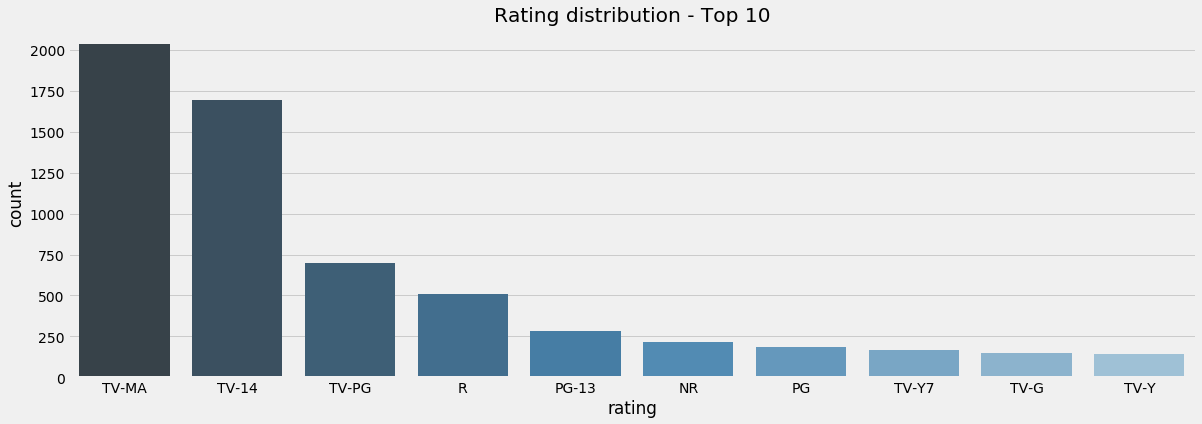

In [198]:
plt.figure(figsize=(18,6))
plt.title("Rating distribution - Top 10")
sea.countplot(x = "rating", 
              order=netflix_data['rating'].value_counts().index[0:10] ,data= netflix_data,palette='Blues_d')

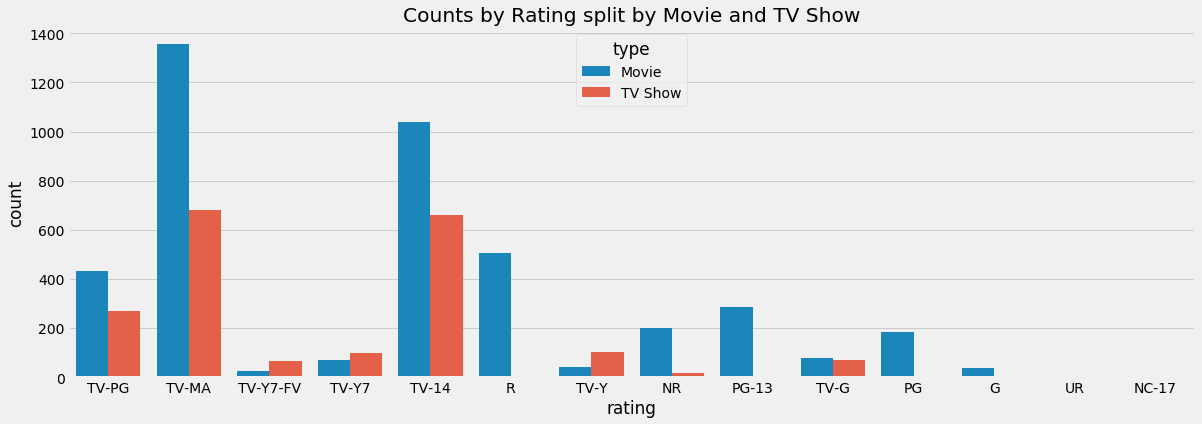

In [204]:

plt.figure(figsize = (18, 6))
sea.countplot(x = 'rating', hue = 'type', data = netflix_data)
plt.title('Counts by Rating split by Movie and TV Show')
plt.show()

"A TV-Y rating means that programming is appropriate for children of all ages. TV-Y7 indicates that programming is designed for chil- dren ages 7 and older" -- *Intresting to see there are more shows in this rating designed for childern than movies*

#### Which are the Top TV Shows by season count? (Question 3)

In [209]:
#Extracting season and converting to int

tv_shows['season']=tv_shows['duration'].str.split(' ',expand=True)[0]
tv_shows['season']=tv_shows['season'].astype(int)

/Users/hrushikesha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/hrushikesha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [210]:
tv_shows['season'][:5]

2     1
3     1
5     1
8     1
26    1
Name: season, dtype: int64

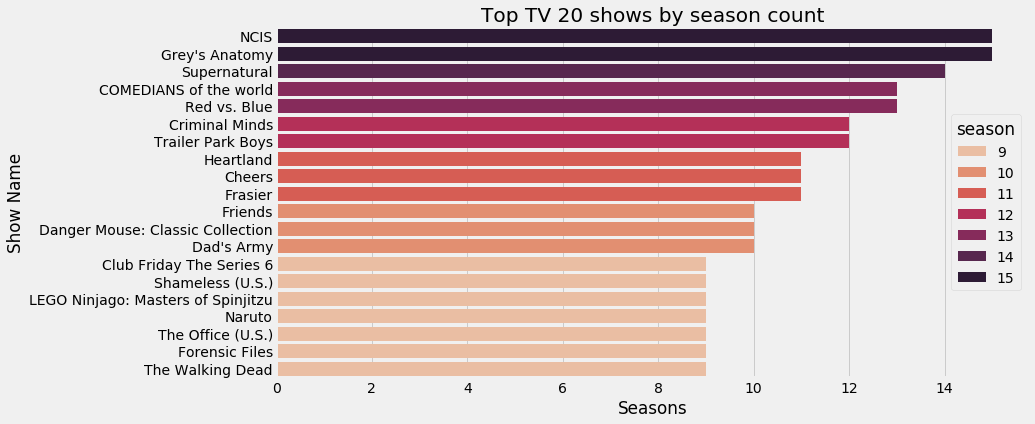

In [230]:
top_20_tv_shows=tv_shows.sort_values(by='season',ascending=False).head(20)
plt.figure(figsize=(12,6))
sea.barplot(data=top_20_tv_shows,y='title',x='season',hue='season',palette='rocket_r', dodge=False)
plt.title('Top TV 20 shows by season count')
plt.xlabel('Seasons')
plt.ylabel('Show Name')
plt.show()

Note that some shows may have been renewed in 2020 that's not captured by the datset

### Building a simple recommender system 


In this part of the analysis I explore to build an Item-Item recommendation system based on cosine similarity. More detailed information about [content based recommendation](https://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243). In principle the items we are considering are movies and TV Shows, so our goal is to find how similar one movie or TV Show is to other. Here we do not need user ratings

Here is the workflow for building the content based recommender system :
1. Utilize the text content in the **description** column of the dataset 
2. Calculate TF-IDF (Term frequencey -Inverse document frequencey)
3. Utilize cosine similarity to get a similarity score of the items here -movies 

In [234]:
#define tf_idf and remove all english stop words 

tf_idf = TfidfVectorizer(stop_words='english')

In [235]:
#construct the tf-idf matrix 

tf_idf_mat = tf_idf.fit_transform(netflix_data['description'])

In [236]:
tf_idf_mat.shape

(6234, 16151)

The Vocabulary consists of approximately 16k words that are used to describe 6k Movies and TV Shows

In [237]:
#Cosine Similarity 

cosine_similarity_netflix_data = cosine_similarity(tf_idf_mat, tf_idf_mat)

In [238]:
cosine_similarity_netflix_data.shape

(6234, 6234)

In [241]:
names_movie_tv = pd.Series(netflix_data.index, index=netflix_data['title']).drop_duplicates()

In [247]:
# function that provides Recommendations for movies and TV Shows

def get_recommendations(title, n =11, cosine_similarity_netflix_data=cosine_similarity_netflix_data):
    
    '''
    the function takes a title of the movie or TV Show and provides recommendations. It has 3 parameters : 
    title, number, n  which is the number of similar movie recommendation you want.
    It takes a default value of 11 if not specified and the cosine similarity matrix that was created 
    in the previous step
    
    '''
    movie_tv_show_names = names_movie_tv[title]
    similarity_score = list(enumerate(cosine_similarity_netflix_data[movie_tv_show_names]))
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    similarity_score = similarity_score[1:n]
    tv_show_movie_indices = [i[0] for i in similarity_score]

    return netflix_data['title'].iloc[tv_show_movie_indices]

In [251]:
get_recommendations('The Irishman')

2679    Rolling Thunder Revue: A Bob Dylan Story by Ma...
2023                   Why We Fight: The Battle of Russia
4153                        The Irishman: In Conversation
3490                                  Catch Me If You Can
4004                      Metallica: Some Kind of Monster
1657    Steve Martin and Martin Short: An Evening You ...
4770                                     Detention Letter
4629                      Martin Lawrence Live: Runteldat
5949                       Home: Adventures with Tip & Oh
5532                                     Mandobasar Galpo
Name: title, dtype: object

The recommender works ! **The Irishmen** Genre is 'Drama/Crime' so is **Catch me if you can** also the **The Irishman: In Conversation** is a documentary based on the actual movie. **The Irishman** is also a biography so we also see **Rolling Thunder Revue: A Bob Dylan Story** and **Metallica: Some Kind of Monster** in the mix